# Fractions Skill Score Verification - Single Hazard

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
import pysteps
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

Pysteps configuration file found at: /anaconda3/envs/pyEAE/lib/python3.9/site-packages/pysteps/pystepsrc



### Defintions for Coarsening

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    #load the geog file produce for WRF-BCC
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    #coarsen the dataset to ~80-km
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    #assign lat/lon values of coarsen data and set index
    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

## Create Widgets

In [4]:
#widget for selecting variable
var_widget = widgets.RadioButtons(
    options=[('Updraft Helicity', 'UH'), ('Updraft Vertical Velocity', 'UVV'), ('Downdraft Vertical Velocity', 'DVV')],
    layout={'width': 'max-content'},
    description='Variable:',
    disabled=False)

In [5]:
#widget for selecting hazard
haz_widget = widgets.RadioButtons(
    options=[('Tornado', 'tor'), ('Hail', 'hail'), ('Wind', 'wind')],
    layout={'width': 'max-content'},
    description='Hazard:',
    disabled=False)

In [6]:
#widget for selecting reflectivity range
refc_widget = widgets.IntRangeSlider(
    value=[40, 50],
    min=40,
    max=65,
    step=5,
    description='Reflectivity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [7]:
#widget for selecting reflectivity range
UVV_widget = widgets.IntRangeSlider(
    value=[18, 24],
    min=18,
    max=35,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [8]:
#widget for selecting reflectivity range
UH_widget = widgets.IntRangeSlider(
    value=[35, 70],
    min=35,
    max=150,
    step=5,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [9]:
#widget for selecting reflectivity range
DVV_widget = widgets.IntRangeSlider(
    value=[2, 8],
    min=2,
    max=15,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [10]:
neigh_widget = widgets.IntSlider(
    value=200,
    min=0,
    max=3000,
    step=10,
    description='Pixel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [11]:
thres_widget = widgets.IntSlider(
    value=20,
    min=0,
    max=200,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

### Loading WRF-BCC Variable Data
The widget below allows you to select which WRF-BCC variable to currently test. NOTE: if you change the variable, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [12]:
#First Widget!
var_widget

RadioButtons(description='Variable:', layout=Layout(width='max-content'), options=(('Updraft Helicity', 'UH'),…

In [13]:
#load wrf-bcc dataset
df_wrf = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_{var_widget.value}_REFC_regrid_threshold_dataframe.csv')

In [14]:
#convert from raw count to convective days
df_wrf['Time'] = pd.to_datetime(df_wrf['Time'])
df_wrf['New_Time'] = pd.to_datetime(df_wrf['Time']) + pd.DateOffset(hours=12)

#seperate timing values into their own column
df_wrf['Year'] = pd.to_datetime(df_wrf['New_Time']).dt.year
df_wrf['Month'] = pd.to_datetime(df_wrf['New_Time']).dt.month
df_wrf['Day'] = pd.to_datetime(df_wrf['New_Time']).dt.day

#drop duplicate days
df_wrf = df_wrf.drop_duplicates(subset=['coarse_lat','coarse_lon','Year', 'Month','Day'])
df_wrf

,Unnamed: 0.1,Unnamed: 0,x,y,Time,UH,DBZ,UVV,coarse_lat,coarse_lon,New_Time,Year,Month,Day
0,2,2,749,411,1990-10-31 04:00:00,42.497177,51.801662,17.208110,37.197716,-95.382850,1990-10-31 16:00:00,1990,10,31
1,3,3,750,411,1990-10-31 04:00:00,41.811430,40.762430,13.348378,37.197716,-95.343575,1990-10-31 16:00:00,1990,10,31
2,4,4,750,412,1990-10-31 04:00:00,35.797220,40.055344,12.823191,37.204070,-95.343575,1990-10-31 16:00:00,1990,10,31
3,10,10,655,107,1990-10-31 17:00:00,43.998700,48.578342,25.945530,27.039728,-99.083015,1990-11-01 05:00:00,1990,11,1
5,12,12,656,108,1990-10-31 17:00:00,35.890606,55.929990,13.679318,27.056839,-99.083015,1990-11-01 05:00:00,1990,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052823,3052279,222452,906,676,2005-09-30 00:00:00,43.327316,53.837643,8.723131,45.767197,-87.560280,2005-09-30 12:00:00,2005,9,30
1052824,3052280,222453,907,676,2005-09-30 00:00:00,37.712870,43.664204,6.150899,45.744907,-87.508750,2005-09-30 12:00:00,2005,9,30
1052825,3052281,222454,905,677,2005-09-30 00:00:00,37.796368,51.491848,6.550873,45.798760,-87.601630,2005-09-30 12:00:00,2005,9,30
1052826,3052282,222455,906,677,2005-09-30 00:00:00,40.048130,52.623300,6.997382,45.790220,-87.548485,2005-09-30 12:00:00,2005,9,30


In [15]:
#create an array of zeros
zeros = np.zeros((899,1399))

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_wrf.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
#nan all the zero values    
zeros[zeros == 0.0] = np.nan

#assign the array to the netcdf file
ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

#coarsen the file 
ds_cor = Data_Conv(ds)

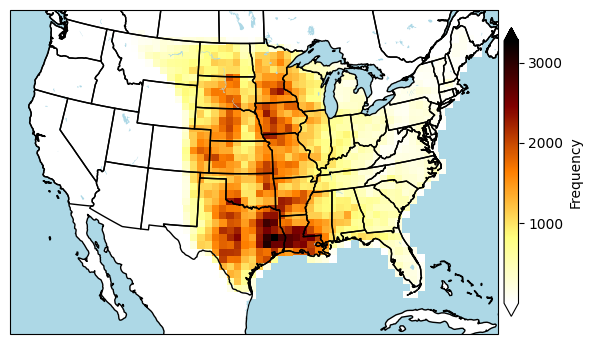

In [16]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 1000)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Loading SPC Local Storm Report Data
The widget below allows you to select which hazard from the SPC LSR data archive file to currently test. NOTE: if you change the hazard, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [17]:
#Second Widget!
haz_widget

RadioButtons(description='Hazard:', layout=Layout(width='max-content'), options=(('Tornado', 'tor'), ('Hail', …

In [18]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_obs = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_{haz_widget.value}_fix.csv')

In [19]:
#add the lat and lon columns based on values in the nearest column
lat = []
lon = []

#iterate through each row to find the lat/lon
for rid, row in df_obs.iterrows():
    lat.append(row.Nearest.split()[1])
    lon.append(row.Nearest.split()[7])

#append the values to the dataframe
df_obs['Lat'] = lat
df_obs['Lon'] = lon

#combine date and time to a datetime object
df_obs['datetime'] = pd.to_datetime(df_obs['date'] + ' ' + df_obs['time']) + pd.DateOffset(hours=6)
df_obs['con_date'] = (df_obs['datetime'] + pd.DateOffset(hours=12)).dt.date

#drop duplicates to convert to convective days
df_obs = df_obs.drop_duplicates(subset=['Lat','Lon','con_date'])
%timeit
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,f1,f2,f3,f4,fc,Nearest,Lat,Lon,datetime,con_date
0,0,28866,1056,1990,10,11,1990-10-11,13:30:00,3,FL,...,17,0,0,0,0,"(675 28.726412\nName: lat, dtype: float32, ...",28.726412,-82.624176,1990-10-11 19:30:00,1990-10-12
1,1,28867,1057,1990,10,11,1990-10-11,13:50:00,3,FL,...,23,0,0,0,0,"(813 30.041531\nName: lat, dtype: float32, ...",30.041531,-82.376007,1990-10-11 19:50:00,1990-10-12
2,2,28868,1058,1990,10,11,1990-10-11,19:40:00,3,GA,...,25,0,0,0,0,"(951 31.360302\nName: lat, dtype: float32, ...",31.360302,-82.119484,1990-10-12 01:40:00,1990-10-12
3,3,28869,1059,1990,10,13,1990-10-13,11:35:00,3,NY,...,105,0,0,0,0,"(2129 41.887657\nName: lat, dtype: float32,...",41.887657,-75.095139,1990-10-13 17:35:00,1990-10-14
4,4,28870,1060,1990,10,18,1990-10-18,10:15:00,3,VA,...,137,0,0,0,0,"(1713 38.250511\nName: lat, dtype: float32,...",38.250511,-78.00528,1990-10-18 16:15:00,1990-10-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18801,18801,48927,413,2005,9,2,2005-09-02,12:52:00,3,TX,...,355,0,0,0,0,"(448 27.783375\nName: lat, dtype: float32, ...",27.783375,-97.856163,2005-09-02 18:52:00,2005-09-03
18802,18802,48928,1165,2005,9,5,2005-09-05,18:50:00,3,ND,...,17,0,0,0,0,"(2381 46.582943\nName: lat, dtype: float32,...",46.582943,-96.990036,2005-09-06 00:50:00,2005-09-06
18805,18805,48931,333,2005,9,5,2005-09-05,19:26:00,3,KS,...,199,0,0,0,0,"(1617 39.127338\nName: lat, dtype: float32,...",39.127338,-101.392448,2005-09-06 01:26:00,2005-09-06
18806,18806,48932,331,2005,9,6,2005-09-06,18:53:00,3,NE,...,17,0,0,0,0,"(1895 41.86729\nName: lat, dtype: float32, ...",41.86729,-99.738342,2005-09-07 00:53:00,2005-09-07


In [20]:
#create an array of zeros
zeros = np.zeros((ds_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_cor.lat.values == float(row.Lat))
    y2, x2 = np.where(ds_cor.lon.values == float(row.Lon))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

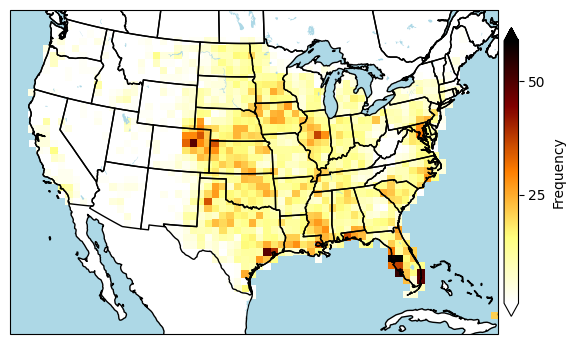

In [21]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_obs.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 25)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Verfication Testing
There are a few widgets below, so pay attention to what each on of them does:

* **First Widget:** Controls the reflectivity range values to test on with a step interval of 5 (e.g., a range of 40-50 will test 40, 45, and 50 dBZ).
* **Second Widget:** Controls the range of values of the tested variable. These update based on the variable inputted, therefore make sure to rerun it properly. 
* **Third Widget:** Controls the neighborhood size used during the verification (e.g., 100 pixels is a 10x10 neighborhood).
* **Fourth Widget:** Controls the threshold for binarzation [e.g., 12 convective days threshold means all values above (below) become a 1 (0)]


NOTE: if you changed anything above (especially the variable), you will need to rerun the cells below that widget again. Run the cell above the widget prior to making a selection. Please adjust the widget to the desired range or value. Slowly repeat these steps for each of the widgets. 

In [22]:
# Reflectivity Widget (First)
refc_widget

IntRangeSlider(value=(40, 50), continuous_update=False, description='Reflectivity:', max=65, min=40, step=5)

In [23]:
# Varaible Widget (Second)
locals()[f'{var_widget.value}_widget']

IntRangeSlider(value=(35, 70), continuous_update=False, description='Range:', max=150, min=35, step=5)

In [24]:
# Neighborhood Widget (Third)
neigh_widget

IntSlider(value=200, continuous_update=False, description='Pixel:', max=3000, step=10)

In [25]:
# Threshold Widget (Fourth)
thres_widget

IntSlider(value=20, continuous_update=False, description='Threshold:', max=200)

### Verification with FSS

In [26]:
#Set the step value based on the variable used.
if var_widget.value == 'UH':
    step = 5

else:
    step = 1

In [27]:
#create a new dataframe
df = pd.DataFrame(columns=['DBZ', 'VAR', 'FSS'])

#iterate through VAR and Z values for subsetting
for refc in np.arange(refc_widget.value[0],refc_widget.value[1]+1,5):
    for var in np.arange(locals()[f'{var_widget.value}_widget'].value[0], locals()[f'{var_widget.value}_widget'].value[1]+1, step):
        
        #subset the dataframe based on current threshold values
        df_sub = df_wrf[((df_wrf['DBZ'] >= refc) & (df_wrf[var_widget.value] >= var))]
        
        #create an array of zeros
        zeros = np.zeros((899,1399))

        #iterate through each row of the dataframe to and add one for each instance 
        for rid, row in df_sub.iterrows():
            zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1

        #nan all the zero values    
        zeros[zeros == 0.0] = np.nan

        #assign the array to the netcdf file
        ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

        #coarsen the file 
        ds_cor = Data_Conv(ds)
        
        #verify with FSS!
        fss = pysteps.verification.spatialscores.fss(ds_cor.UP_HELI_MAX.values, ds_obs.UP_HELI_MAX.values, 50, 100)
        
        print(f'VAR:{var}   DBZ:{refc}   DIFF:{len(df_obs) - len(df_sub)}   FSS:{fss}')
        df = df.append({'DBZ': refc, 'VAR': var, 'DIFF':len(df_obs) - len(df_sub), 'FSS':fss}, ignore_index=True)

VAR:35   DBZ:40   DIFF:-910307   FSS:0.007481818644142546
VAR:40   DBZ:40   DIFF:-676405   FSS:0.007716029047689199
VAR:45   DBZ:40   DIFF:-512831   FSS:0.007994856723376964
VAR:50   DBZ:40   DIFF:-394946   FSS:0.008343785927853564
VAR:55   DBZ:40   DIFF:-307594   FSS:0.00880342478757501
VAR:60   DBZ:40   DIFF:-242051   FSS:0.00927966964989868
VAR:65   DBZ:40   DIFF:-192067   FSS:0.00983425594651921
VAR:70   DBZ:40   DIFF:-153479   FSS:0.01032877419602618
VAR:35   DBZ:45   DIFF:-639684   FSS:0.007635438884039281
VAR:40   DBZ:45   DIFF:-479170   FSS:0.007946405417439295
VAR:45   DBZ:45   DIFF:-365649   FSS:0.008331608481045194
VAR:50   DBZ:45   DIFF:-283199   FSS:0.008815788433556793
VAR:55   DBZ:45   DIFF:-221550   FSS:0.009283754996830429
VAR:60   DBZ:45   DIFF:-174838   FSS:0.009928228530335592
VAR:65   DBZ:45   DIFF:-138813   FSS:0.010423859319636186
VAR:70   DBZ:45   DIFF:-110875   FSS:0.011123938610960171
VAR:35   DBZ:50   DIFF:-385147   FSS:0.00806445445538162
VAR:40   DBZ:50   D

### Plot Verification Results

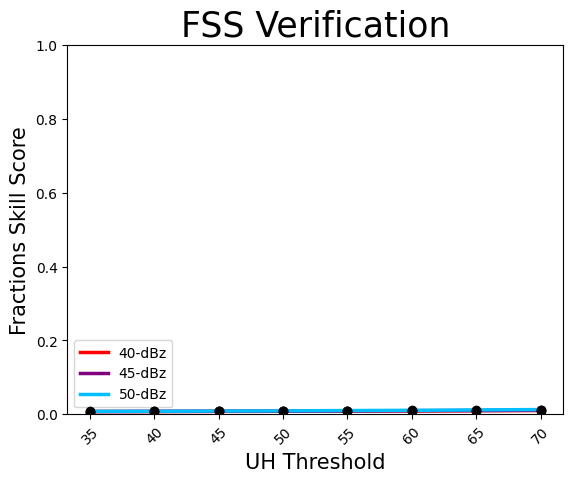

In [28]:
arange = np.arange(locals()[f'{var_widget.value}_widget'].value[0], locals()[f'{var_widget.value}_widget'].value[1]+1, step)

#plot the scores of the FSS
plt.plot(np.arange(1,len(arange)+1,1), df.FSS.values[:len(arange)], color = 'red', lw=2.5)
plt.plot(np.arange(1,len(arange)+1,1), df.FSS.values[len(arange):2*len(arange)], color = 'purple', lw=2.5)
plt.plot(np.arange(1,len(arange)+1,1), df.FSS.values[2*len(arange):], color = 'deepskyblue', lw=2.5)

plt.scatter(np.arange(1,len(arange)+1,1), df.FSS.values[:len(arange)], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(arange)+1,1), df.FSS.values[len(arange):2*len(arange)], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(arange)+1,1), df.FSS.values[2*len(arange):], color = 'black', zorder=10)

plt.title('FSS Verification',fontsize=25)

plt.yticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(ticks = np.arange(1,len(arange)+1,1), labels = arange, rotation=45)

plt.xlabel(f'{var_widget.value} Threshold', size = 15)
plt.ylabel('Fractions Skill Score', size = 15)

plt.legend(['40-dBz', '45-dBz', '50-dBz'], loc ='lower left')